# Feature Extraction

In this notebook, we will extract some features from the EEG signals

In [1]:
%load_ext autoreload
%autoreload 2
import os
os.chdir("..")

In [2]:
%matplotlib inline
from IPython.core.debugger import Tracer
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
from scipy.signal import welch
from IPython.core.debugger import Tracer
from sklearn_pandas import DataFrameMapper, cross_val_score
from p300.feature_extraction import BaseTransformer

# How should it be in the script

In [3]:
df = pd.read_csv("output/output.csv")

df = df.iloc[:20]

df.columns

Index(['id', 'array_path', 'ch_names', 'event_time', 'event_type', 'index',
       'sfreq', 'subject_id'],
      dtype='object')

In [4]:
# %load -s LoadArray p300/feature_extraction/preprocessing.py
class LoadArray(BaseTransformer):
    """Load numpy array transformer."""

    def __init__(self, remove_sti=True):
        """Constructor.

        Parameters
        ----------

        remove_sti: Boolean (default true)
            Indicates whether to remove the Stimulus channel
        """
        self.remove_sti = remove_sti

    def transform(self, x, y=None):
        """Transform method."""
        ret = np.array([np.load(path) for path in x])

        if self.remove_sti:
            # TODO: Remove this hardcoded stuff
            ret = ret[:, :14, :]

        return ret


In [5]:
transformer = DataFrameMapper([
    ('array_path', LoadArray()),
], input_df=True)


In [6]:
signals = transformer.fit_transform(df)

In [7]:
signals.shape

(20, 14, 104)

In [8]:
t = np.arange(-0.10, 0.7, 0.8/104)

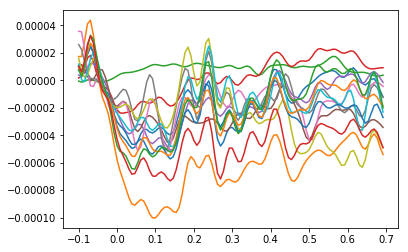

In [9]:
for r in signals[1, :, :]:
    plt.plot(t, r)

# With frequency shit

In [10]:
# %load -s FrequencyExtractor p300/feature_extraction/frequency_extractor.py
class FrequencyExtractor(BaseTransformer):
    """Extractor of plain frequencies."""

    def __init__(self, min_freq=1, max_freq=20):
        """Constructor.

        Parameters:
        ----------

        passband: tuple of floats
            Passband to be returned
        """
        self.min_freq = min_freq
        self.max_freq = max_freq

    def get_feature_names(self):
        """Return name for features."""
        channel_names = "AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4".split(",")

        return ["{}_{}hz".format(ch_name, str(f)) for ch_name in channel_names for f in self.freqs]

    def transform(self, x, y=None):
        """Transform signal.

        Parameters:
        ----------

        x: np.array of channels
            array of nchannels x samples
        """
        self.freqs, magnitudes = welch(x, fs=128, nperseg=100)

        # Remove frequencies not wanted
        max_idx = np.argmax(self.freqs > self.max_freq)  # No more than x hz
        min_idx = np.argmin(self.freqs < self.min_freq)

        self.freqs = self.freqs[min_idx:max_idx]
        # Remove out-of-band frequencies
        magnitudes = magnitudes[:, :, min_idx:max_idx]
        # Reshape it into a 1-d array
        magnitudes = magnitudes.reshape(magnitudes.shape[0], -1)

        return magnitudes


In [11]:
extractor = FrequencyExtractor()
freqs = extractor.fit_transform(signals[0:1])

In [12]:
freqs.shape

(1, 210)

In [13]:
extractor.get_feature_names()

['AF3_1.28hz',
 'AF3_2.56hz',
 'AF3_3.84hz',
 'AF3_5.12hz',
 'AF3_6.4hz',
 'AF3_7.68hz',
 'AF3_8.96hz',
 'AF3_10.24hz',
 'AF3_11.52hz',
 'AF3_12.8hz',
 'AF3_14.08hz',
 'AF3_15.36hz',
 'AF3_16.64hz',
 'AF3_17.92hz',
 'AF3_19.2hz',
 'F7_1.28hz',
 'F7_2.56hz',
 'F7_3.84hz',
 'F7_5.12hz',
 'F7_6.4hz',
 'F7_7.68hz',
 'F7_8.96hz',
 'F7_10.24hz',
 'F7_11.52hz',
 'F7_12.8hz',
 'F7_14.08hz',
 'F7_15.36hz',
 'F7_16.64hz',
 'F7_17.92hz',
 'F7_19.2hz',
 'F3_1.28hz',
 'F3_2.56hz',
 'F3_3.84hz',
 'F3_5.12hz',
 'F3_6.4hz',
 'F3_7.68hz',
 'F3_8.96hz',
 'F3_10.24hz',
 'F3_11.52hz',
 'F3_12.8hz',
 'F3_14.08hz',
 'F3_15.36hz',
 'F3_16.64hz',
 'F3_17.92hz',
 'F3_19.2hz',
 'FC5_1.28hz',
 'FC5_2.56hz',
 'FC5_3.84hz',
 'FC5_5.12hz',
 'FC5_6.4hz',
 'FC5_7.68hz',
 'FC5_8.96hz',
 'FC5_10.24hz',
 'FC5_11.52hz',
 'FC5_12.8hz',
 'FC5_14.08hz',
 'FC5_15.36hz',
 'FC5_16.64hz',
 'FC5_17.92hz',
 'FC5_19.2hz',
 'T7_1.28hz',
 'T7_2.56hz',
 'T7_3.84hz',
 'T7_5.12hz',
 'T7_6.4hz',
 'T7_7.68hz',
 'T7_8.96hz',
 'T7_10.24hz'

# Full pipeline

Hagamos el Pipeline ahora

In [22]:
from sklearn.pipeline import make_pipeline

load_array = DataFrameMapper([
    ('array_path', LoadArray()),
], input_df=True)

pipe = make_pipeline(load_array, FrequencyExtractor())

In [42]:
df = pd.read_csv("output/test_preinstances.csv")

print(df.ch_names.unique())

['AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,STI 014']


In [43]:

out = pipe.fit_transform(df_sliced)

feature_names = pipe.named_steps['frequencyextractor'].get_feature_names()

df = pd.concat([
    df, 
    pd.DataFrame(out, columns=feature_names)
], axis=1)


In [44]:
df

,id,array_path,ch_names,event_time,event_type,index,sfreq,subject_id,AF3_1.28hz,AF3_2.56hz,...,AF4_7.68hz,AF4_8.96hz,AF4_10.24hz,AF4_11.52hz,AF4_12.8hz,AF4_14.08hz,AF4_15.36hz,AF4_16.64hz,AF4_17.92hz,AF4_19.2hz
0,29426001_0,/home/jmperez/projects/p300-jmp/output/npy/294...,"AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,...",641,1,0,128.0,29426001,8.185372e-11,1.433065e-10,...,1.535409e-11,1.039691e-12,4.562640e-12,3.430115e-12,3.369744e-12,5.696224e-12,7.725425e-12,1.282880e-11,1.056752e-14,5.485074e-12
1,29426001_1,/home/jmperez/projects/p300-jmp/output/npy/294...,"AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,...",673,1,1,128.0,29426001,5.602706e-11,6.102775e-12,...,1.576653e-12,6.344459e-12,2.400146e-12,4.387928e-12,1.816632e-12,2.747622e-13,8.029992e-12,1.803087e-11,1.044199e-11,2.079670e-12
2,29426001_2,/home/jmperez/projects/p300-jmp/output/npy/294...,"AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,...",705,1,2,128.0,29426001,8.676295e-11,2.249411e-11,...,5.927889e-12,5.373420e-12,3.492587e-12,2.067411e-12,1.877360e-13,2.289885e-12,6.139794e-12,2.620743e-12,1.367629e-12,1.332073e-12
3,29426001_3,/home/jmperez/projects/p300-jmp/output/npy/294...,"AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,...",737,1,3,128.0,29426001,9.071296e-11,5.744061e-11,...,1.273629e-12,5.936934e-13,1.693757e-12,1.330492e-12,4.269030e-13,1.664101e-12,3.163917e-12,5.369368e-13,1.884027e-12,1.773334e-12
4,29426001_4,/home/jmperez/projects/p300-jmp/output/npy/294...,"AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,...",769,1,4,128.0,29426001,2.104811e-12,9.784077e-12,...,1.459067e-11,5.730728e-12,7.434836e-13,2.975306e-13,3.533121e-12,8.352857e-12,7.620510e-12,1.937840e-12,3.836612e-13,9.620462e-15
5,29426001_5,/home/jmperez/projects/p300-jmp/output/npy/294...,"AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,...",801,1,5,128.0,29426001,1.971104e-12,2.859642e-12,...,1.054226e-11,8.479222e-13,1.075333e-12,1.707310e-12,3.534489e-12,3.231715e-13,3.066439e-12,2.217764e-13,1.223800e-13,2.737875e-13
6,29426001_6,/home/jmperez/projects/p300-jmp/output/npy/294...,"AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,...",833,1,6,128.0,29426001,2.414598e-11,1.097688e-11,...,3.422187e-12,4.138968e-12,2.082088e-12,6.159226e-13,5.366155e-12,5.366368e-12,2.320717e-12,2.287774e-13,4.884797e-13,1.512177e-12
7,29426001_7,/home/jmperez/projects/p300-jmp/output/npy/294...,"AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,...",865,1,7,128.0,29426001,5.206363e-11,4.533781e-11,...,3.326701e-12,3.897210e-13,5.775267e-12,4.947054e-12,4.504889e-13,9.886642e-13,1.245503e-12,4.213442e-13,3.338608e-13,3.232939e-13
8,29426001_8,/home/jmperez/projects/p300-jmp/output/npy/294...,"AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,...",897,1,8,128.0,29426001,3.534565e-11,2.272843e-11,...,8.673429e-12,4.686100e-12,1.564691e-12,1.431018e-12,1.819766e-12,6.450316e-13,5.137390e-13,4.530497e-13,3.348107e-14,7.650715e-14
9,29426001_9,/home/jmperez/projects/p300-jmp/output/npy/294...,"AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,...",929,1,9,128.0,29426001,1.068414e-10,2.113062e-11,...,1.138662e-12,1.154146e-12,7.252828e-13,3.524415e-14,3.883979e-13,2.610478e-13,1.208112e-12,2.606370e-13,3.255094e-13,5.340889e-13
